In [3]:
# Install cartopy

!conda install --yes cartopy

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\snoda\anaconda3

  added / updated specs:
    - cartopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cartopy-0.18.0             |   py38h80a4efb_1         1.7 MB
    geos-3.8.0                 |       h33f27b4_0         905 KB
    proj-6.2.1                 |       h9f7ef89_0         7.9 MB
    pyshp-2.1.3                |     pyhd3eb1b0_0          37 KB
    shapely-1.7.1              |   py38h210f175_0         374 KB
    ------------------------------------------------------------
                                           Total:        10.8 MB

The following NEW packages will be INSTALLED:

  cartopy            pkgs/main/win-64::cartopy-0.18.0-py38h80a4efb_1
  geos               pkgs/main/win-64::geos-3.8.0-h33f27b4_0
  proj               pkgs/main/win-64::proj-6.2.1-h9f7ef89_0
  pyshp   

In [8]:
pip install boto3

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install metpy

  Using cached MetPy-1.0.1-py3-none-any.whl (330 kB)
  Using cached xarray-0.18.2-py3-none-any.whl (807 kB)
  Using cached pooch-1.4.0-py3-none-any.whl (51 kB)
  Using cached Pint-0.17-py2.py3-none-any.whl (204 kB)
Note: you may need to restart the kernel to use updated packages.


In [10]:
import boto3
from datetime import datetime
from botocore import UNSIGNED
from botocore.client import Config
import matplotlib.pyplot as plt
from metpy.io import Level2File
from metpy.plots import add_timestamp, ctables
import cartopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [25]:
# Create s3 resource
s3 = boto3.resource("s3", config=Config(signature_version=UNSIGNED, user_agent_extra='Resource'))

# Create bucket
bucket = s3.Bucket("noaa-nexrad-level2")

In [33]:
pip install siphon

Note: you may need to restart the kernel to use updated packages.


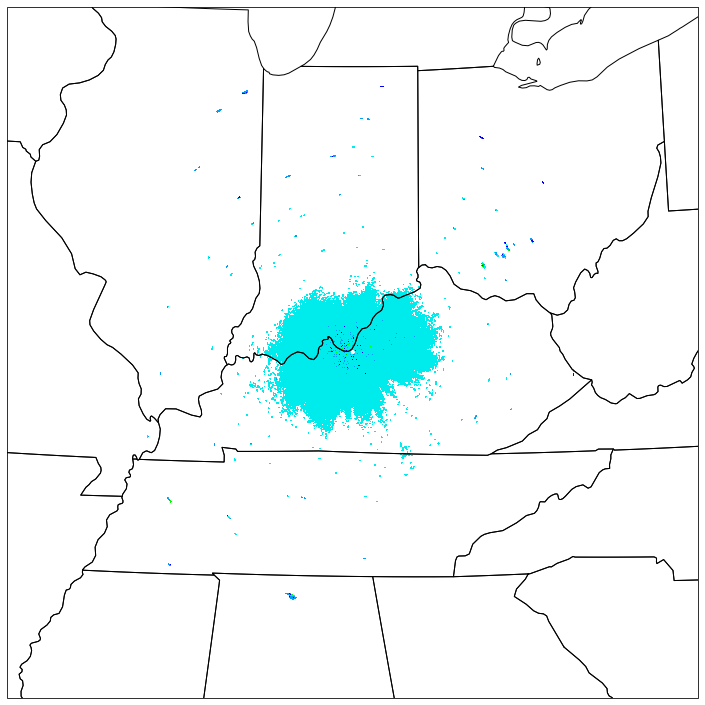

In [47]:
# Download the single latest volume of a specific radar instance
# This will utilize radar station KLVX (Louisville, KY)

from siphon.radarserver import RadarServer

rs = RadarServer('http://tds-nexrad.scigw.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')

from datetime import datetime, timedelta
query = rs.query()
query.stations('KLVX').time(datetime.utcnow())

rs.validate_query(query)

catalog = rs.get_catalog(query)

catalog.datasets

data = catalog.datasets[0].remote_access()

import numpy as np
def raw_to_masked_float(var, data):
    # Values come back signed. If the _Unsigned attribute is set, we need to convert
    # from the range [-127, 128] to [0, 255].
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

sweep = 0
ref_var = data.variables['Reflectivity_HI']
ref_data = ref_var[sweep]
rng = data.variables['distanceR_HI'][:]
az = data.variables['azimuthR_HI'][sweep]

ref = raw_to_masked_float(ref_var, ref_data)
x, y = polar_to_cartesian(az, rng)

import metpy.plots as mpplots
ref_norm, ref_cmap = mpplots.ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def new_map(fig, lon, lat):
    # Create projection centered on the radar. This allows us to use x
    # and y relative to the radar.
    proj = ccrs.LambertConformal(central_longitude=lon, central_latitude=lat)

    # New axes with the specified projection
    ax = fig.add_axes([0.02, 0.02, 0.96, 0.96], projection=proj)

    # Add coastlines and states
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    
    return ax

fig = plt.figure(figsize=(10, 10))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)
ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)

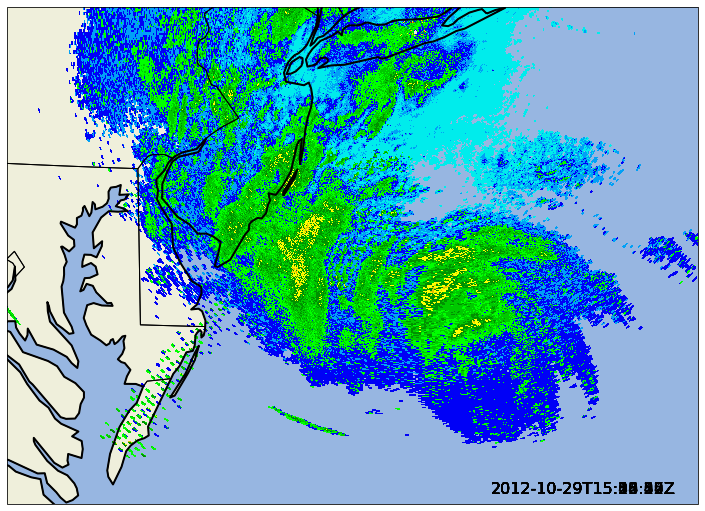

In [57]:
# Download a collection of historical data based on a longitute, latitude point and using a time range

query = rs.query()
dt = datetime(2012, 10, 29, 15) # Our specified time
query.lonlat_point(-73.687, 41.175).time_range(dt, dt + timedelta(hours=1))

cat = rs.get_catalog(query)
cat.datasets

ds = cat.datasets[0]
data = ds.remote_access()
fig = plt.figure(figsize=(10, 7.5))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)

# Set limits in lat/lon space
ax.set_extent([-77, -70, 37, 41])

ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))


# Now we can loop over the collection of returned datasets and plot them. As we plot, we collect the returned plot objects so that we can use them to make an animated plot. We also add a timestamp for each plot.

meshes = []
for ds_name in cat.datasets:
    # After looping over the list of sorted datasets, pull the actual Dataset object out
    # of our list of items and access over CDMRemote
    data = cat.datasets[ds_name].remote_access()

    # Pull out the data of interest
    sweep = 0
    rng = data.variables['distanceR_HI'][:]
    az = data.variables['azimuthR_HI'][sweep]
    ref_var = data.variables['Reflectivity_HI']

    # Convert data to float and coordinates to Cartesian
    ref = raw_to_masked_float(ref_var, ref_var[sweep])
    x, y = polar_to_cartesian(az, rng)

    # Plot the data and the timestamp
    mesh = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
    text = ax.text(0.7, 0.02, data.time_coverage_start, transform=ax.transAxes,
                   fontdict={'size':16})
    
    # Collect the things we've plotted so we can animate
    meshes.append((mesh, text))
    


In [66]:
# Using matplotlib, we can take a collection of Artists that have been plotted and turn them into an animation. Using the FFMpeg utility, this animation can be converted to HTML5 video viewable in the notebook.

# Set up matplotlib to do the conversion to HTML5 video
import matplotlib
plt.rcParams['animation.ffmpeg_path'] = 'C:/ffmpeg/bin'
matplotlib.rcParams['animation.html'] = 'html5'


In [67]:
conda install -c conda-forge ffmpeg

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\snoda\anaconda3

  added / updated specs:
    - ffmpeg


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.2               |   py38haa244fe_0         3.1 MB  conda-forge
    ffmpeg-4.3.1               |       ha925a31_0        26.2 MB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        29.2 MB

The following NEW packages will be INSTALLED:

  ffmpeg             conda-forge/win-64::ffmpeg-4.3.1-ha925a31_0
  python_abi         conda-forge/win-64::python_abi-3.8-2_cp38

The following packages will be UPDATED:

  conda              pkgs/main::conda-4.10.1-py38haa95532_1 --> conda-forge::conda-4.10.2-py38haa244fe_0




python_abi-3.8

In [68]:

# Create an animation

from matplotlib.animation import ArtistAnimation
ArtistAnimation(fig, meshes)

RuntimeError: Requested MovieWriter (ffmpeg) not available